In [1]:
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torch
from torch import nn
from torchvision.models import efficientnet_b0, efficientnet_b2, resnet50, EfficientNet_B0_Weights, EfficientNet_B2_Weights, ResNet50_Weights
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import shutil
from PIL import Image
import requests
from timeit import default_timer as timer

In [2]:
# download my pre_written training scripts from github
with open('torch_engine.py', 'wb') as f:
    request = requests.get(url='https://raw.githubusercontent.com/mrkomoruyi/pytorch-deep-learning/main/torch_engine.py')
    f.write(request.content)
    f.close()

import torch_engine

In [3]:
root = Path('/kaggle/input/100-bird-species')
train_path = root/'train'
valid_path = root/'valid'
test_path = root/'test'

classes = os.listdir(train_path)
num_classes = len(classes)

In [4]:
def_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale = True)
])
train_transforms = transforms.Compose([
    transforms.AutoAugment(),
    def_transforms
])

train_data = ImageFolder(root=train_path, transform = train_transforms)
valid_data = ImageFolder(root=valid_path, transform = def_transforms)
test_data = ImageFolder(root=test_path, transform = def_transforms)

# creating a subset of the training data for quick experimentation
class CustomDatasetMini(Dataset):
    def __init__(self, root_dir, num_images_per_class, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images in standard ImageFolder format.
            num_images_per_class (int): Number of images to use from each class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.num_images_per_class = num_images_per_class
        self.transform = transform

        # Load the dataset using ImageFolder
        self.dataset = ImageFolder(root=root_dir)
        
        # Filter the dataset to only include the specified number of images per class
        self.filtered_dataset = self._filter_dataset()

    def _filter_dataset(self):
        class_to_idx = self.dataset.class_to_idx
        idx_to_class = {v: k for k, v in class_to_idx.items()}
        filtered_data = []

        for class_idx in range(len(class_to_idx)):
            class_images = [img for img, label in self.dataset.samples if label == class_idx]
            selected_images = random.sample(class_images, min(self.num_images_per_class, len(class_images)))
            filtered_data.extend([(img, class_idx) for img in selected_images])

        return filtered_data

    def __len__(self):
        return len(self.filtered_dataset)

    def __getitem__(self, idx):
        img_path, label = self.filtered_dataset[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
train_data_mini = CustomDatasetMini(root_dir='/kaggle/input/100-bird-species/train', num_images_per_class=30, transform=train_transforms)
valid_data_mini = CustomDatasetMini(root_dir='/kaggle/input/100-bird-species/valid', num_images_per_class=30, transform=def_transforms)

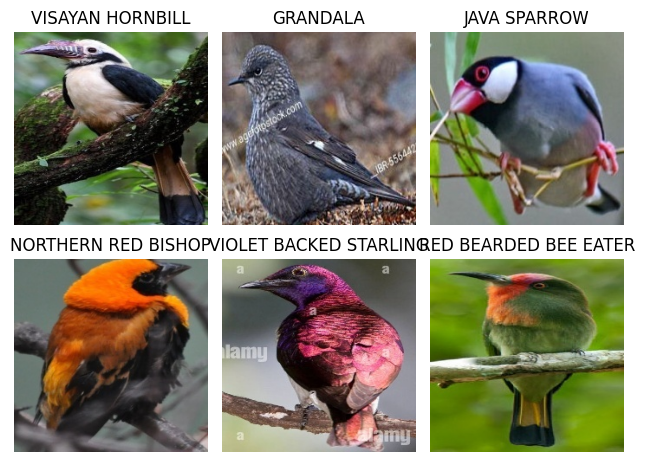

In [6]:
# visualize a few images in the dataset
r_imgs = random.sample(train_data.imgs, k = 6)
for i,img in enumerate(r_imgs):
    plt.subplot(2,3,i+1)
    plt.imshow(Image.open(img[0]))
    plt.title(train_data.classes[img[1]])
    plt.axis('off')
plt.tight_layout()

In [7]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True, pin_memory = True)
valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False, drop_last = True, pin_memory = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False, drop_last = True, pin_memory = True)

train_loader_mini = DataLoader(train_data_mini, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
valid_loader_mini = DataLoader(valid_data_mini, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False, drop_last = True)

## Model Building

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = {'efficientnet_b0': efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT, progress = False).to(device), 'efficientnet_b2': efficientnet_b2(weights = EfficientNet_B2_Weights.DEFAULT, progress = 
False).to(device)}

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


In [9]:
for model_name, model in models.items():
    # freezing the bottom layers
    for param in model.parameters():
        param.requires_grad = False
    
    if model_name == 'efficientnet_b0':
        model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace = True),
        nn.Linear(in_features = 1280, out_features = num_classes, bias = True)
    ).to(device)
    elif model_name == 'efficientnet_b2':
        model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace = True),
        nn.Linear(in_features = 1408, out_features = num_classes, bias = True)
    ).to(device)
    elif model_name == 'resnet50':
        model.fc = nn.Linear(in_features = 2048, out_features = num_classes, bias = True)
    else:
        print('model architecture not supported')

## Model Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizers = {}
for model_name, model in models.items():
    optimizers[model_name] = torch.optim.Adam(params = model.parameters())

In [11]:
histories = {}
for model_name, model in models.items():
    start = timer()
    histories[model_name] = {}
    histories[model_name]['train'], histories[model_name]['test']=torch_engine.train_and_test_model(epochs = 2,model = model, model_type = 'multiclass', num_classes = num_classes, criterion = criterion, optimizer = optimizers[model_name], verbose = False, device = device, model_name = model_name, train_dataloader = train_loader_mini, test_dataloader = valid_loader_mini, checkpoint_path = '/kaggle/working')
    end = timer()
    print(f'train time for {model_name} = {end-start:.3f}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0
{'Model name': 'efficientnet_b0', 'test_loss': 2.8189809438658924, 'test_accuracy': 67.53048780487805} 
--------------------
Epoch:  1
{'Model name': 'efficientnet_b0', 'test_loss': 1.6474583846766775, 'test_accuracy': 76.0670731707317} 
--------------------
train time for efficientnet_b0 = 66.723


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0
{'Model name': 'efficientnet_b2', 'test_loss': 2.827236762860926, 'test_accuracy': 69.20731707317073} 
--------------------
Epoch:  1
{'Model name': 'efficientnet_b2', 'test_loss': 1.6506936666442127, 'test_accuracy': 77.40091463414635} 
--------------------
train time for efficientnet_b2 = 65.441


In [12]:
# I'll use the efficientnet_b0 model for final training
history = {}

start = timer()
history['train'], history['test']=torch_engine.train_and_test_model(epochs = 3,model = models['efficientnet_b0'], model_type = 'multiclass', num_classes = num_classes, criterion = criterion, optimizer = optimizers['efficientnet_b0'], verbose = True, device = device, model_name = 'efficientnet_b0', train_dataloader = train_loader, test_dataloader = valid_loader, checkpoint_path = '/kaggle/working')
end = timer()
print(f'train time for efficientnet_b0 = {end-start:.3f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:  0
Loss: 1.86890 | Accuracy: 64.03%
{'Model name': 'efficientnet_b0', 'test_loss': 0.5835287062133231, 'test_accuracy': 88.26219512195122} 
--------------------
Epoch:  1
Loss: 1.38705 | Accuracy: 70.44%
{'Model name': 'efficientnet_b0', 'test_loss': 0.4627046468781262, 'test_accuracy': 89.82469512195122} 
--------------------
Epoch:  2
Loss: 1.22018 | Accuracy: 73.03%
{'Model name': 'efficientnet_b0', 'test_loss': 0.3844492649886666, 'test_accuracy': 91.0060975609756} 
--------------------
train time for efficientnet_b0 = 412.924


In [13]:
#evaluate the model on unseen data
eval_metrics = torch_engine.eval_model(models['efficientnet_b0'], model_type = 'multiclass', criterion = criterion, device = device, test_dataloader = test_loader)

In [14]:
eval_metrics

{'Model name': 'EfficientNet',
 'test_loss': 0.30697409954012894,
 'test_accuracy': 93.21646341463415}